The purpose of this notebook is to investigate the effect of the sky annulus choice on the surface brightness profiles.

In [1]:
import os
import numpy as np
import fitsio
from astropy.table import Table
from scipy.interpolate import interp1d

In [2]:
from matplotlib.ticker import FormatStrFormatter, MultipleLocator, ScalarFormatter
import matplotlib.pyplot as plt

In [3]:
from legacyhalos.misc import arcsec2kpc, plot_style
from legacyhalos.io import read_ellipsefit
from legacyhalos.hsc import read_sample, get_galaxy_galaxydir
from legacyhalos.ellipse import ellipse_sbprofile

In [4]:
sns, _ = plot_style(font_scale=1)
%matplotlib inline

In [10]:
%env HSC_DATA_DIR=/global/cscratch1/sd/ioannis/hsc-data-skytests

env: HSC_DATA_DIR=/global/cscratch1/sd/ioannis/hsc-data-skytests


In [25]:
sample = Table.read(os.path.join(os.getenv('HSC_DIR'), 'temp-hsc-sample-s16a-lowz.fits'))
#sample = read_sample(verbose=True)
ngal = len(sample)
#sample
ww = np.where(sample['ID_S16A'] == 44191717372486627)[0]
print(ww)
sample[ww]

[13]


NAME,ID_S16A,RA,DEC,Z_BEST,MEAN_E,MEAN_PA
str11,int64,float64,float64,float64,float64,float64
,44191717372486627,140.3414186884024,3.3362808242260567,0.3145900070667267,0.18,79.91


In [12]:
galaxy, galaxydir = get_galaxy_galaxydir(sample)
print(galaxy[0], galaxydir[0])

38540249080554899 /global/cscratch1/sd/ioannis/hsc-data-skytests/8/276/38540249080554899


/global/common/software/desi/cori/desiconda/20190311-1.2.7-img/conda/lib/python3.6/site-packages/ipykernel/__main__.py:10: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.


(0.995, 1.005)

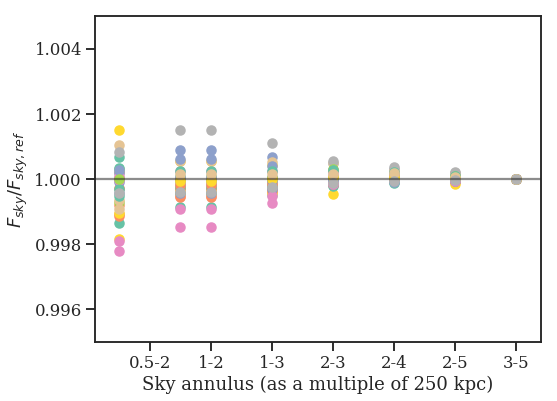

In [20]:
indx = 0
skyfile = os.path.join(galaxydir[indx].replace('/8/', '/8-reference/'), '{}-custom-sky.fits'.format(galaxy[indx]))
sky = fitsio.FITS(skyfile)
factor = 0.262 * arcsec2kpc(sample['Z_BEST'][0])

fig, ax = plt.subplots(figsize=(8, 6))
ax.axhline(y=1, alpha=0.5, color='k')
for ff in sky:
    hdr, data = ff.read_header(), ff.read()
    data = np.delete(data, (4,))
    if 'RADMASK' in hdr:
        radius = (data['skyfactor_out'] - data['skyfactor_in']) / 2 + data['skyfactor_in']
        #radius = factor * hdr['RADMASK'] * ((data['skyfactor_out'] - data['skyfactor_in']) / 2 + 
        #                                    data['skyfactor_in'])
        #ax.scatter(radius, data['skymedian'])
        ax.scatter(radius, data['skymedian'] / data['skymedian'][7])        
ax.set_xlabel('Sky annulus (as a multiple of 250 kpc)')
#ax.set_xticks([0.75, 1.25, 1.5, 2.0, 2.5, 3, 3.5, 4])
ax.set_xticklabels(['0.5-1', '0.5-2', '1-2', '1-3', '2-3', '2-4', '2-5', '3-5'])
#ax.set_xticklabels(['0.5-1', '0.5-2', '1-2', '1-3', '1-4', '2-3', '2-4', '2-5', '3-5'])
ax.set_ylabel(r'$F_{sky} / F_{sky, ref}$')
ax.set_ylim(0.995, 1.005)

In [21]:
sky[1].read(header=True)

array([(0.24875468, 0.24877359, 0.2487938 , 0.00761346, 0.5, 1., False),
       (0.24852206, 0.24858518, 0.24862948, 0.00766299, 0.5, 2., False),
       (0.24852206, 0.24858518, 0.24862948, 0.00766299, 1. , 2., False),
       (0.24840419, 0.24859333, 0.24864806, 0.00763333, 1. , 3., False),
       (0.24845521, 0.2485811 , 0.2486218 , 0.00762346, 1. , 4., False),
       (0.24827304, 0.2485981 , 0.24866582, 0.00760567, 2. , 3., False),
       (0.24842082, 0.24857807, 0.24861698, 0.00760425, 2. , 4., False),
       (0.24845251, 0.248603  , 0.24862632, 0.00759495, 2. , 5.,  True),
       (0.24853851, 0.24860574, 0.24860647, 0.00758934, 3. , 5., False)],
      dtype=[('skymode', '>f4'), ('skymedian', '>f4'), ('skymean', '>f4'), ('skysig', '>f4'), ('skyfactor_in', '>f4'), ('skyfactor_out', '>f4'), ('skyrow_use', '?')])

In [22]:
skyrow2label = {
    'skyrow0': '(0.5-1)*250 kpc',
    'skyrow1': '(0.5-2)*250 kpc',
    'skyrow2': '(1-2)*250 kpc',
    'skyrow3': '(1-3)*250 kpc',
    'skyrow4': '(1-4)*250 kpc',
    'skyrow5': '(2-3)*250 kpc',
    'skyrow6': '(2-4)*250 kpc',
    'reference': '(2-5)*250 kpc (reference)',
    'skyrow8': '(3-5)*250 kpc'
}

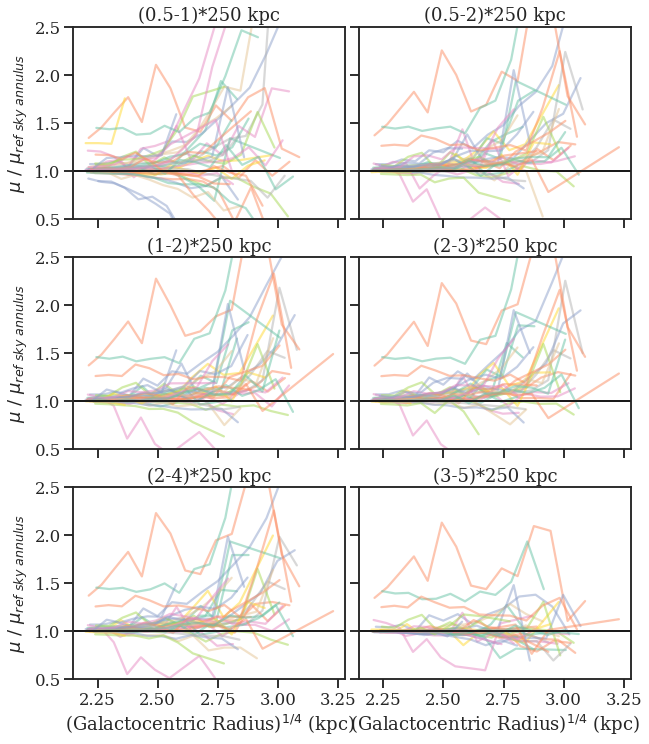

In [23]:
# Read one cluster to get a reference radius.
#refgal = 9
#reffactor = arcsec2kpc(sample['Z_BEST'][refgal])
#dd = '8-reference'
#gdir = galaxydir[igal].replace('/8/', '/{}/'.format(dd))

# Now plot the individual profiles for each choice of sky aperture relative to the nominal one.
fig, ax = plt.subplots(3, 2, figsize=(10, 12), sharey=True, sharex=True)

for ii, (xx, dd) in enumerate(zip(ax.flat, ['8-skyrow0', '8-skyrow1', '8-skyrow2', '8-skyrow5', 
                                            '8-skyrow6', '8-skyrow8'])):
    label = skyrow2label[dd.replace('8-', '')]
    for igal in np.arange(ngal):
        gdir = galaxydir[igal].replace('/8/', '/8-reference/')
        cust = ellipse_sbprofile(read_ellipsefit(galaxy[igal], gdir), linear=True)
        reffactor = arcsec2kpc(sample['Z_BEST'][igal])        
        radius_ref, mu_ref = (reffactor * cust['radius_r'])**0.25, cust['mu_r']
        
        redshift = sample['Z_BEST'][igal]
        factor = arcsec2kpc(redshift)
        
        gdir = galaxydir[igal].replace('/8/', '/{}/'.format(dd))
        ellcust = read_ellipsefit(galaxy[igal], gdir)
        cust = ellipse_sbprofile(ellcust, linear=True)
        radius_cust = (factor * cust['radius_r'])**0.25

        mu_plot = interp1d(radius_cust, cust['mu_r'], bounds_error=False, fill_value=np.nan)(radius_ref)
        good = np.isfinite(mu_plot) * (radius_ref > 2.2)
        xx.plot(radius_ref[good], mu_plot[good] / mu_ref[good], alpha=0.5)
        
    if ii % 2 == 0:
        xx.set_ylabel(r'$\mu\ /\ \mu_{ref\ sky\ annulus}$')

    xx.axhline(y=1, lw=2, color='k')
    xx.set_title(label)
    xx.set_ylim(0.5, 2.5)
    if ii > 3:
        xx.set_xlabel(r'(Galactocentric Radius)$^{1/4}$ (kpc)')
        
    fig.subplots_adjust(wspace=0.05)        

Plot the individual profiles.

44191717372486627 /global/cscratch1/sd/ioannis/hsc-data-skytests/8-reference/426/44191717372486627
[6.71902466e+00 6.28188094e+00 6.24072349e+00 6.19598726e+00
 6.14742712e+00 6.09479712e+00 6.03785537e+00 5.97637046e+00
 5.90871700e+00 5.81892597e+00 5.70943717e+00 5.57874700e+00
 5.42643736e+00 5.24122709e+00 5.03091368e+00 4.79461721e+00
 4.53476431e+00 4.26798766e+00 3.96978485e+00 3.66568368e+00
 3.32885808e+00 2.98423506e+00 2.64757494e+00 2.32783283e+00
 2.00347985e+00 1.72716609e+00 1.48064873e+00 1.25558050e+00
 1.08027683e+00 9.51525980e-01 7.80205874e-01 6.40129688e-01
 5.57476920e-01 4.72954887e-01 4.02672635e-01 3.17780454e-01
 2.81999706e-01 2.32050552e-01 2.06505657e-01 1.68087924e-01
 1.34653040e-01 1.14910270e-01 1.07323330e-01 8.01927841e-02
 6.54708809e-02 4.67419693e-02 3.38251133e-02 2.61136818e-02
 2.26078781e-02 1.50484940e-02 1.08799112e-02 8.36524643e-03
 7.42341183e-03 5.59866055e-03 5.30963735e-03]
[6.69540644e+00 6.25776072e+00 6.21654382e+00 6.17174024e+00


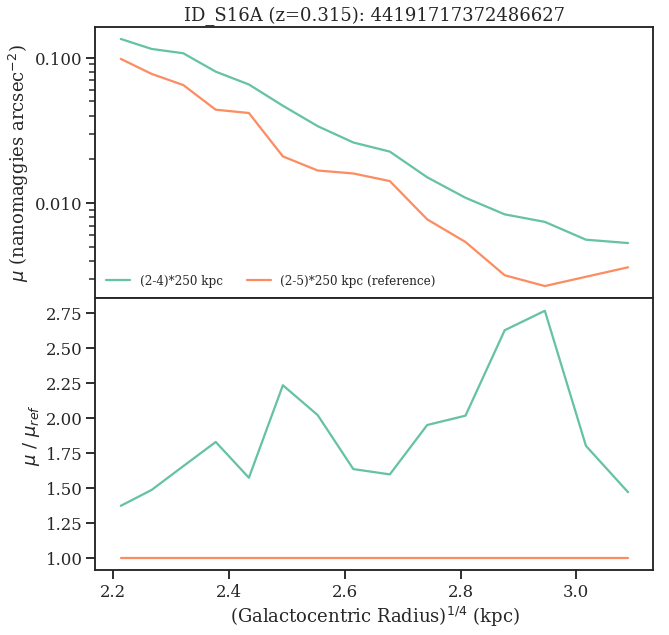

In [33]:
for igal in [13]:
    fig, ax = plt.subplots(2, 1, figsize=(10, 10), sharex=True)
    redshift = sample['Z_BEST'][igal]
    factor = arcsec2kpc(redshift)
    
    # Read the reference profile
    dd = '8-reference'
    gdir = galaxydir[igal].replace('/8/', '/{}/'.format(dd))
    print(galaxy[igal], gdir)
    #ellpipe = read_ellipsefit(galaxy[igal], gdir, filesuffix='pipeline')
    #ellpipe['eps'] = ellcust['geometry'].eps
    #pipe = ellipse_sbprofile(ellpipe, linear=True)
    ellcust = read_ellipsefit(galaxy[igal], gdir, verbose=True)
    cust = ellipse_sbprofile(ellcust, linear=True)
    radius_ref, mu_ref = cust['radius_r'], cust['mu_r']

    for dd in ['8-skyrow6', '8-reference']:
    #for dd in ['8-skyrow0', '8-skyrow1', '8-skyrow2', '8-skyrow5', '8-skyrow6', '8-skyrow8', '8-reference']:
        label = skyrow2label[dd.replace('8-', '')]
        gdir = galaxydir[igal].replace('/8/', '/{}/'.format(dd))
        ellcust = read_ellipsefit(galaxy[igal], gdir, verbose=True)
        cust = ellipse_sbprofile(ellcust, linear=True)

        mu_plot = interp1d(cust['radius_r'], cust['mu_r'], bounds_error=False, fill_value=np.nan)(radius_ref)
        good = np.where(((factor * radius_ref)**0.25 > 2.2) * np.isfinite(mu_plot))[0]
        #print(mu_ref[good], mu_plot)
        print(mu_plot)
        
        ax[0].plot((factor * radius_ref[good])**0.25, mu_plot[good], label=label)
        ax[1].plot((factor * radius_ref[good])**0.25, mu_plot[good] / mu_ref[good])

    ax[0].set_title('ID_S16A (z={:.3f}): {}'.format(redshift, sample['ID_S16A'][igal]))
    ax[0].set_yscale('log')
    #ax[1].set_ylim(0.5, 2.2)
    ax[0].set_ylabel(r'$\mu$ (nanomaggies arcsec$^{-2}$)')
    ax[1].set_xlabel(r'(Galactocentric Radius)$^{1/4}$ (kpc)')
    ax[1].set_ylabel(r'$\mu\ /\ \mu_{{ref}}$')
    ax[0].legend(loc='lower left', ncol=2, frameon=False, fontsize=12)
    ax[0].get_yaxis().set_major_formatter(ScalarFormatter())
    #for xx in ax:
    #    xx.autoscale(tight=True)
    #    xx.set_xlim(2, 3)
    fig.subplots_adjust(hspace=0)